###installing packegs

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.22.2
!pip install -q decord qwen_vl_utils

In [2]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
from qwen_vl_utils import process_vision_info
import warnings
import os
import math
import hashlib
import requests

from IPython.display import Markdown, display
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


###loading model and processor from ulsloth

In [3]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-2B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.10.12: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.41G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

###utilis

In [4]:
def download_video(url, dest_path):
    response = requests.get(url, stream=True)
    with open(dest_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8096):
            f.write(chunk)
    print(f"Video downloaded to {dest_path}")


def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
    os.makedirs(cache_dir, exist_ok=True)

    video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
    if video_path.startswith('http://') or video_path.startswith('https://'):
        video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
        if not os.path.exists(video_file_path):
            download_video(video_path, video_file_path)
    else:
        video_file_path = video_path

    frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
    timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

    if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
        frames = np.load(frames_cache_file)
        timestamps = np.load(timestamps_cache_file)
        return video_file_path, frames, timestamps

    vr = VideoReader(video_file_path, ctx=cpu(0))
    total_frames = len(vr)

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = vr.get_batch(indices).asnumpy()
    timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

    np.save(frames_cache_file, frames)
    np.save(timestamps_cache_file, timestamps)

    return video_file_path, frames, timestamps


def create_image_grid(images, num_columns=8):
    pil_images = [Image.fromarray(image) for image in images]
    num_rows = math.ceil(len(images) / num_columns)

    img_width, img_height = pil_images[0].size
    grid_width = num_columns * img_width
    grid_height = num_rows * img_height
    grid_image = Image.new('RGB', (grid_width, grid_height))

    for idx, image in enumerate(pil_images):
        row_idx = idx // num_columns
        col_idx = idx % num_columns
        position = (col_idx * img_width, row_idx * img_height)
        grid_image.paste(image, position)

    return grid_image

def inference(video, prompt, max_new_tokens=2048, total_pixels=20480 * 32 * 32, min_pixels=64 * 32 * 32, max_frames= 2048, sample_fps = 2):
    """
    Perform multimodal inference on input video and text prompt to generate model response.

    Args:
        video (str or list/tuple): Video input, supports two formats:
            - str: Path or URL to a video file. The function will automatically read and sample frames.
            - list/tuple: Pre-sampled list of video frames (PIL.Image or url).
              In this case, `sample_fps` indicates the frame rate at which these frames were sampled from the original video.
        prompt (str): User text prompt to guide the model's generation.
        max_new_tokens (int, optional): Maximum number of tokens to generate. Default is 2048.
        total_pixels (int, optional): Maximum total pixels for video frame resizing (upper bound). Default is 20480*32*32.
        min_pixels (int, optional): Minimum total pixels for video frame resizing (lower bound). Default is 16*32*32.
        sample_fps (int, optional): ONLY effective when `video` is a list/tuple of frames!
            Specifies the original sampling frame rate (FPS) from which the frame list was extracted.
            Used for temporal alignment or normalization in the model. Default is 2.

    Returns:
        str: Generated text response from the model.

    Notes:
        - When `video` is a string (path/URL), `sample_fps` is ignored and will be overridden by the video reader backend.
        - When `video` is a frame list, `sample_fps` informs the model of the original sampling rate to help understand temporal density.
    """

    messages = [
        {"role": "user", "content": [
                {"video": video,
                "total_pixels": total_pixels,
                "min_pixels": min_pixels,
                "max_frames": max_frames,
                'sample_fps':sample_fps},
                {"type": "text", "text": prompt},
            ]
        },
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True,
                                                                   image_patch_size= 16,
                                                                   return_video_metadata=True)
    if video_inputs is not None:
        video_inputs, video_metadatas = zip(*video_inputs)
        video_inputs, video_metadatas = list(video_inputs), list(video_metadatas)
    else:
        video_metadatas = None
    inputs = tokenizer(text=[text], images=image_inputs, videos=video_inputs, video_metadata=video_metadatas, **video_kwargs, do_resize=False, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]


### infernce

In [5]:
!wget https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4

--2025-11-02 11:11:15--  https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4
Resolving duguang-labelling.oss-cn-shanghai.aliyuncs.com (duguang-labelling.oss-cn-shanghai.aliyuncs.com)... 8.133.135.105
Connecting to duguang-labelling.oss-cn-shanghai.aliyuncs.com (duguang-labelling.oss-cn-shanghai.aliyuncs.com)|8.133.135.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7753760 (7.4M) [video/mp4]
Saving to: ‘50221078283.mp4’

50221078283.mp4     100%[===================>]   7.39M  4.01MB/s    in 1.8s    

2025-11-02 11:11:18 (4.01 MB/s) - ‘50221078283.mp4’ saved [7753760/7753760]



In [6]:
video_url = "/content/dava.mp4"
prompt = "what is happining in the video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=150)

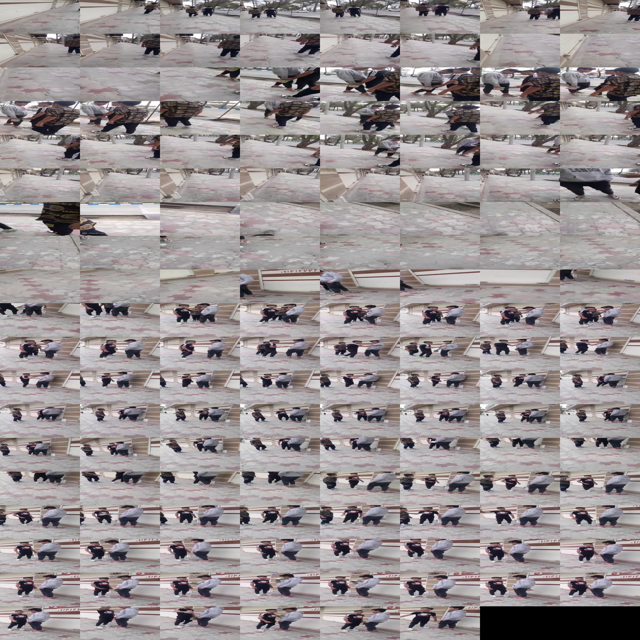

In [7]:
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

In [8]:
response = inference(video_path, prompt)
display(Markdown(response))

qwen-vl-utils using decord to read video.


In the video, a group of young men are walking down a sidewalk. They stop and engage in conversation while holding a bag of chips. One of the men in the group is seen giving the bag to another man who is wearing a grey hoodie. The men continue to talk and gesture with their hands while standing on the sidewalk. The video captures their interaction and conversation as they walk and talk.